In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from mtcnn.mtcnn import MTCNN
import os
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
detector = MTCNN()

In [3]:
# Load the models
emotion_model = load_model('vggface_emotion_6896.h5')
race_model = load_model('vggface_race_67_this.h5')
gender_model = load_model('vggface_gender_9744.h5')
age_model = load_model('vggface_age_focal_combined_57.h5')

In [56]:
def preprocess_face(face, target_size=(224, 224)):
    # face = load_img(face, target_size=target_size)
    face = cv.resize(face, target_size)
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    face = face / 255.0
    return face

def preprocess_face_emotion(face, target_size=(224, 224)):
    # This function is used to preprocess the face for the emotion model
    # It converts the image to grayscale and then resizes it
    face = cv.cvtColor(face, cv.COLOR_RGB2GRAY)
    face = cv.resize(face, target_size)
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    face = face / 255.0
    # Go back to 3 channels
    face = np.repeat(face, 3, axis=3)
    return face


def race2label(id):
    if id == 0:
        return "Black"
    if id == 1:
        return "East Asian"
    if id == 2:
        return "Indian"    
    if id == 3:
        return "Latino"  
    if id == 4:
        return "Middle Eastern"  
    if id == 5:
        return "White"
    
def emotion2label(id):
    if id == 0:
        return "Angry"
    if id == 1:
        return "Disgust"
    if id == 2:
        return "Fear"    
    if id == 3:
        return "Happy"  
    if id == 4:
        return "Neutral"  
    if id == 5:
        return "Sad"
    if id == 6:
        return "Surprise"
    

def gender2label(id):
    if id <= 0.5:
        return "Female"
    return "Male"
    
def age2label(id):
    if id == 0:
        return "0-2"
    elif id == 1:
        return "10-19"
    elif id == 2:
        return "20-29"
    elif id == 3:
        return "3-9"
    elif id == 4:
        return "30-39"
    elif id == 5:
        return "40-49"
    elif id == 6:
        return "50-59"
    elif id == 7:
        return "60-69"
    elif id == 8:
        return "70+"

In [57]:
def random_colors(N):
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

1/1 [==============================] - 0s 68ms/step


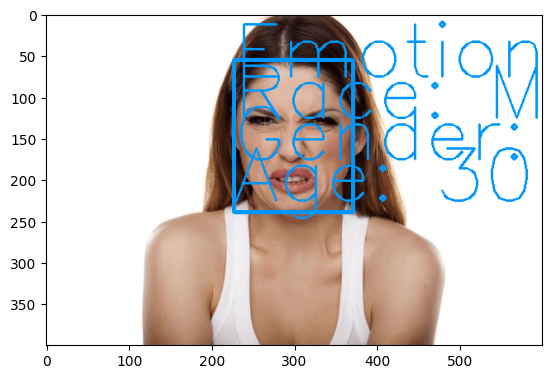

Emotion:  ['Disgust']
Age:  ['30-39']
Race:  ['Middle Eastern']
Gender:  ['Female']


In [64]:
# img = cv.imread('./faces/double_ibo.jpeg')
# img = cv.imread('./faces/cumali.jpeg')
# img = cv.imread('./faces/yekku.jpg')
# img = cv.imread('./faces/erto.jpg')
# img = cv.imread('./faces/cemre6.jpg')
# img = cv.imread('./faces/bayzans.jpeg')



# img = cv.imread('./faces/angry_man.png')
img = cv.imread('./faces/disgusted_woman.png')
# img = cv.imread('./faces/feared_man.png')
# img = cv.imread('./faces/sad_man.png')
# img = cv.imread('./faces/surprised_woman.png')
# img = cv.imread('./faces/happy_woman.png')
# img = cv.imread('./faces/neutral_man.png')

# Convert to RGB
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

results = detector.detect_faces(img)

age_log = []
emotion_log = []
race_log = []
gender_log = []


i = 0
for result in results:
    if result['confidence'] < 0.85:
        continue
    i += 1
    x, y, w, h = result['box']
    face = img[y:y+h, x:x+w]

    # Preprocess the face, face is in RGB format
    processed_face = preprocess_face(face)
    processed_face_emotion = preprocess_face_emotion(face)

    # Predict emotion, race, and gender
    emotion_index = emotion_model.predict(processed_face_emotion)
    race_index = race_model.predict(processed_face)
    gender_index = gender_model.predict(processed_face)
    age_index = age_model.predict(processed_face)

    # Get the labels
    emotion = emotion2label(np.argmax(emotion_index))
    race = race2label(np.argmax(race_index))
    gender = gender2label((gender_index))
    age = age2label(np.argmax(age_index))

    # Log the results
    age_log.append(age)
    gender_log.append(gender)
    emotion_log.append(emotion)
    race_log.append(race)

    if i == 1:
        color = (0, 150, 250)
    else:
        color = random_colors(1)[0]
    # Draw rectangle
    cv.rectangle(img, (x, y), (x+w, y+h), color, 3)

    # Prepare text
    text_lines = [
        f'Emotion: {emotion}',
        f'Race: {race}',
        f'Gender: {gender}',
        f'Age: {age}'
    ]

    # Define starting Y position for text
    text_y_start = y + 20

    # Put text from top left of the rectangle towards bottom
    for line in text_lines:
        cv.putText(img, line, (x, text_y_start), cv.FONT_HERSHEY_SIMPLEX, 3, color, 2)
        text_y_start += 50  # Move to the next line

if age_log != []:
    plt.imshow(img)
    plt.show()
    print("Emotion: ", emotion_log)
    print("Age: ", age_log)
    print("Race: ", race_log)
    print("Gender: ", gender_log)    
else:
    print("No face detected!")


In [28]:
gender_index

array([[0.5936295]], dtype=float32)